In [ ]:
# When running for the first time, run in terminal to set up the environment:
    # python -m venv env
    # Set-ExecutionPolicy -ExecutionPolicy Bypass -Scope Process
    # .\env\Scripts\activate
    # pip install -r requirements.txt

In [1]:
import os
import glob
import soundfile as sf
import torch
import pandas as pd
from audiobox_aesthetics.infer import initialize_predictor
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

c:\GitHub\audio-aesthetics\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [78]:
def main():
    audio_dir = r"C:\GitHub\audio-aesthetics\assets"
    audio_files = glob.glob(os.path.join(audio_dir, "*.wav")) + glob.glob(os.path.join(audio_dir, "*.mp3"))
    
    predictor = initialize_predictor()
    
    batch_data = []
    for fpath in audio_files:
        data, sr = sf.read(fpath)
        audio_tensor = torch.tensor(data, dtype=torch.float32).T
        batch_data.append({"path": audio_tensor, "sample_rate": sr, "filename": fpath})
    
    # Forward pass over all files
    predictions = predictor.forward(batch_data)
    
    results = []
    for pred, info in zip(predictions, batch_data):
        ce_val = pred.get("CE", None)
        cu_val = pred.get("CU", None)
        pc_val = pred.get("PC", None)
        pq_val = pred.get("PQ", None)
        
        file_name = os.path.basename(info["filename"])
        results.append([
            file_name,
            ce_val,
            cu_val,
            pc_val,
            pq_val
        ])
    
    # Rename columns in the final DataFrame
    df_scores = pd.DataFrame(results, columns=[
        "file",
        "content-enjoyment",
        "content-usefulness",
        "production-complexity",
        "production-quality"
    ])
    print(df_scores)
    df_scores.to_csv("results/aesthetics_results.csv", index=False)

    return df_scores  # <-- return it so it's accessible

if __name__ == "__main__":
    df_scores = main()


c:\GitHub\audio-aesthetics\env\lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
c:\GitHub\audio-aesthetics\env\lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


                             file  content-enjoyment  content-usefulness  \
0                 lineare_a2a.wav           7.297026            7.631387   
1                 lineare_ace.wav           5.886321            6.453405   
2          lineare_fiorentini.wav           7.197011            7.041038   
3            lineare_garofalo.wav           6.113775            4.880628   
4   lineare_hai-assicurazione.wav           5.740927            6.343976   
5            lineare_postepay.wav           6.809984            6.938411   
6             lineare_seresto.wav           5.346477            4.627346   
7              lineare_suzuki.wav           5.964487            4.844994   
8            playlist_bernina.mp3           6.759501            5.221873   
9            playlist_citroen.mp3           5.785450            6.332827   
10           playlist_melinda.mp3           6.228623            6.047773   
11   playlist_natural-trainer.mp3           6.344067            5.609169   
12       pla

In [79]:
# Function to extract mode and brand
def extract_mode_brand(filename):
    base = os.path.splitext(filename)[0]  # remove extension
    parts = base.split('_')
    mode = parts[0] if len(parts) > 0 else None
    brand = parts[1] if len(parts) > 1 else None
    return mode, brand

# Apply extraction
df_scores[['mode', 'brand']] = df_scores['file'].apply(lambda x: pd.Series(extract_mode_brand(x)))

# Reorder columns: keep File first, then mode and brand, then all remaining columns
cols = ['file', 'mode', 'brand'] + [col for col in df_scores.columns if col not in ['file', 'mode', 'brand']]
df_scores = df_scores[cols]

# Display result
print(df_scores)

                             file      mode              brand  \
0                 lineare_a2a.wav   lineare                a2a   
1                 lineare_ace.wav   lineare                ace   
2          lineare_fiorentini.wav   lineare         fiorentini   
3            lineare_garofalo.wav   lineare           garofalo   
4   lineare_hai-assicurazione.wav   lineare  hai-assicurazione   
5            lineare_postepay.wav   lineare           postepay   
6             lineare_seresto.wav   lineare            seresto   
7              lineare_suzuki.wav   lineare             suzuki   
8            playlist_bernina.mp3  playlist            bernina   
9            playlist_citroen.mp3  playlist            citroen   
10           playlist_melinda.mp3  playlist            melinda   
11   playlist_natural-trainer.mp3  playlist    natural-trainer   
12       playlist_parmareggio.mp3  playlist        parmareggio   
13           playlist_repower.mp3  playlist            repower   
14        

In [80]:
# Define the allowed brands
allowed_brands = ['repower', 'citroen', 'bernina', 'tenderly']

# Apply the exclusion logic
df_scores['exclude_flag'] = (
    (df_scores['mode'] == 'playlist') & (~df_scores['brand'].isin(allowed_brands))
).astype(int)

# Reorder columns: File, mode, brand, exclude_flag, then the rest
cols = ['file', 'mode', 'brand', 'exclude_flag'] + [
    col for col in df_scores.columns if col not in ['file', 'mode', 'brand', 'exclude_flag']
]
df_scores = df_scores[cols]

# Display result
print(df_scores)


                             file      mode              brand  exclude_flag  \
0                 lineare_a2a.wav   lineare                a2a             0   
1                 lineare_ace.wav   lineare                ace             0   
2          lineare_fiorentini.wav   lineare         fiorentini             0   
3            lineare_garofalo.wav   lineare           garofalo             0   
4   lineare_hai-assicurazione.wav   lineare  hai-assicurazione             0   
5            lineare_postepay.wav   lineare           postepay             0   
6             lineare_seresto.wav   lineare            seresto             0   
7              lineare_suzuki.wav   lineare             suzuki             0   
8            playlist_bernina.mp3  playlist            bernina             0   
9            playlist_citroen.mp3  playlist            citroen             0   
10           playlist_melinda.mp3  playlist            melinda             1   
11   playlist_natural-trainer.mp3  playl

In [84]:
# Import the table
df_recall = pd.read_excel(r"C:\GitHub\audio-aesthetics\tables\table_recall.xlsx")

# Group by 'brand' and 'condition' and calculate ratios
df_recall_aggregated = df_recall.groupby(['brand', 'condition', 'mode']).agg({
    'unaided': lambda x: x.sum() / x.count(),
    'aided': lambda x: x.sum() / x.count()
}).reset_index()

print(df_recall_aggregated)

                brand  condition      mode   unaided     aided
0                 a2a  demanding    linear  0.225000  0.275000
1                 a2a    relaxed    linear  0.257143  0.342857
2                 ace  demanding    linear  0.075000  0.075000
3                 ace    relaxed    linear  0.114286  0.228571
4             bernina  demanding  playlist  0.055556  0.166667
5             bernina    relaxed  playlist  0.075000  0.125000
6             citroen  demanding  playlist  0.111111  0.166667
7             citroen    relaxed  playlist  0.125000  0.175000
8          fiorentini  demanding    linear  0.025000  0.100000
9          fiorentini    relaxed    linear  0.057143  0.314286
10           garofalo  demanding    linear  0.100000  0.150000
11           garofalo    relaxed    linear  0.171429  0.285714
12  hai-assicurazione  demanding    linear  0.000000  0.000000
13  hai-assicurazione    relaxed    linear  0.028571  0.028571
14            melinda  demanding  playlist  0.027778  0

In [97]:
# Subset df_scores where exclude_flag == 0
df = df_recall_aggregated

# Create mapping dictionaries from df_scores
exclude_flag_dict = df_scores.set_index('brand')['exclude_flag'].to_dict()
content_enjoyment_dict = df_scores.set_index('brand')['content-enjoyment'].to_dict()
content_usefulness_dict = df_scores.set_index('brand')['content-usefulness'].to_dict()
production_complexity_dict = df_scores.set_index('brand')['production-complexity'].to_dict()
production_quality_dict = df_scores.set_index('brand')['production-quality'].to_dict()

# Map the values into df
df['exclude_flag'] = df['brand'].map(exclude_flag_dict)
df['content-enjoyment'] = df['brand'].map(content_enjoyment_dict)
df['content-usefulness'] = df['brand'].map(content_usefulness_dict)
df['production-complexity'] = df['brand'].map(production_complexity_dict)
df['production-quality'] = df['brand'].map(production_quality_dict)

df['is-demanding'] = (df['condition'] == 'demanding').astype(int)
df['is-playlist'] = (df['mode'] == 'playlist').astype(int)
df['is-invented-brand'] = df['brand'].isin(['hai-assicurazione', 'bernina']).astype(int)

# Get current columns
cols = list(df.columns)

# Move 'unaided' and 'aided' to the end
cols = [col for col in cols if col not in ['unaided', 'aided']] + ['unaided', 'aided']

# Reorder dataframe
df = df[cols]

# Display result
print(df)



                brand  condition      mode  exclude_flag  content-enjoyment  \
0                 a2a  demanding    linear             0           7.297026   
1                 a2a    relaxed    linear             0           7.297026   
2                 ace  demanding    linear             0           5.886321   
3                 ace    relaxed    linear             0           5.886321   
4             bernina  demanding  playlist             0           6.759501   
5             bernina    relaxed  playlist             0           6.759501   
6             citroen  demanding  playlist             0           5.785450   
7             citroen    relaxed  playlist             0           5.785450   
8          fiorentini  demanding    linear             0           7.197011   
9          fiorentini    relaxed    linear             0           7.197011   
10           garofalo  demanding    linear             0           6.113775   
11           garofalo    relaxed    linear          

In [126]:
import statsmodels.api as sm

# 'brand'
# 'condition'
# 'exclude_flag'
# 'content-enjoyment'
# 'content-usefulness'
# 'production-complexity'
# 'production-quality'
# 'is-demanding'
# 'is-playlist'

# 'unaided'
# 'aided'

# Filter out records where exclude_flag == 1
df_filtered = df[(df['exclude_flag'] != 1) & (df['is-invented-brand'] != 1)]

# Define independent variables (X) and dependent variable (y)
X = df_filtered[['production-quality']]
y = df_filtered['aided']

# Add constant to X for intercept
X = sm.add_constant(X)

# Fit linear regression model
model = sm.OLS(y, X).fit()

# Display regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  aided   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     5.859
Date:                Mon, 09 Jun 2025   Prob (F-statistic):             0.0263
Time:                        14:40:55   Log-Likelihood:                 21.374
No. Observations:                  20   AIC:                            -38.75
Df Residuals:                      18   BIC:                            -36.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.8062      0

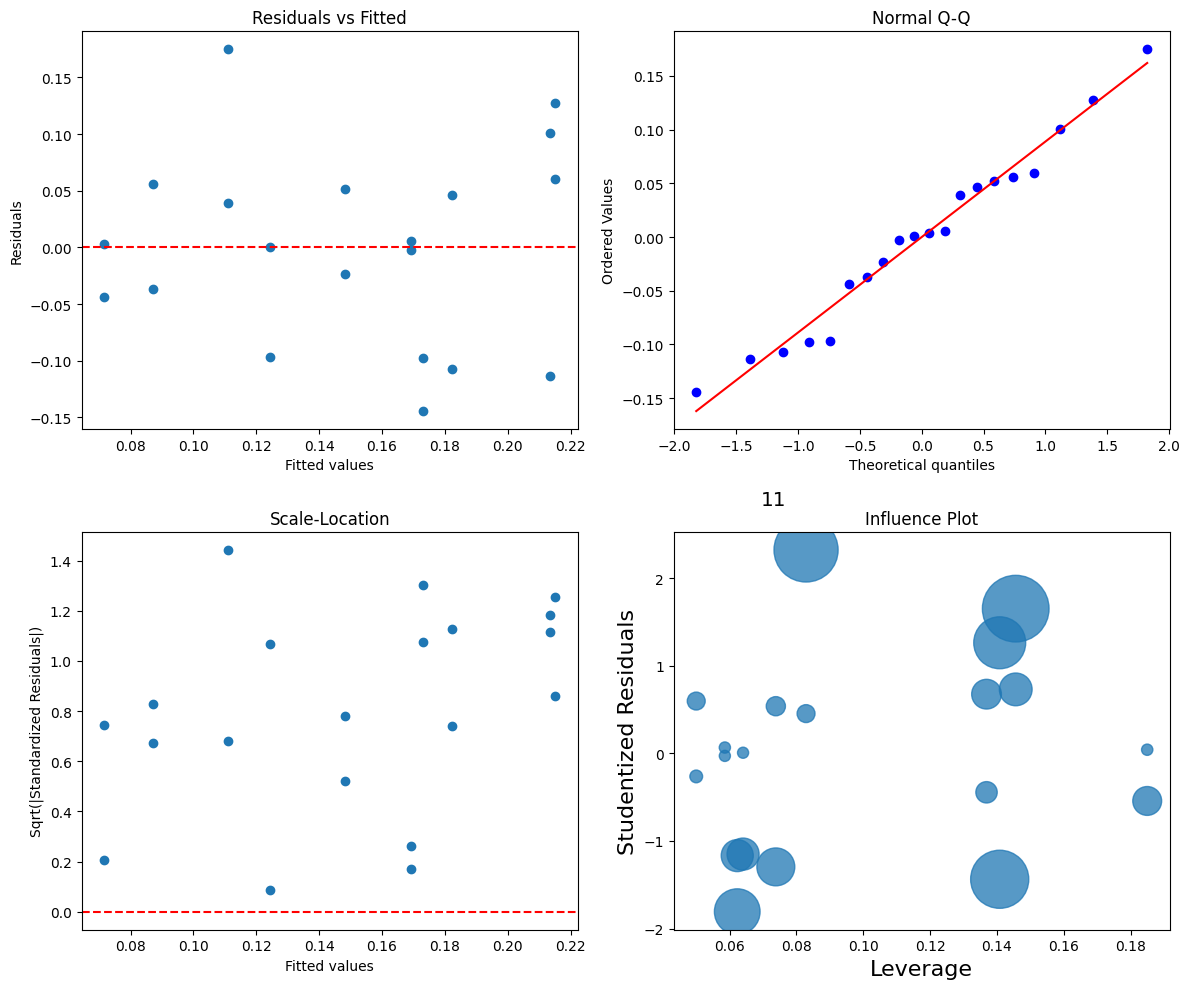

In [127]:
fitted_vals = model.fittedvalues
residuals = model.resid

# Extract fitted values and residuals
fitted_vals = model.fittedvalues
residuals = model.resid
standardized_residuals = model.get_influence().resid_studentized_internal
sqrt_abs_resid = np.sqrt(np.abs(standardized_residuals))

# Create 2x2 plot grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residuals vs Fitted
axs[0, 0].scatter(fitted_vals, residuals)
axs[0, 0].axhline(0, color='red', linestyle='--')
axs[0, 0].set_xlabel("Fitted values")
axs[0, 0].set_ylabel("Residuals")
axs[0, 0].set_title("Residuals vs Fitted")

# 2. Normal Q-Q
stats.probplot(residuals, dist="norm", plot=axs[0, 1])
axs[0, 1].set_title("Normal Q-Q")

# 3. Scale-Location
axs[1, 0].scatter(fitted_vals, sqrt_abs_resid)
axs[1, 0].axhline(0, color='red', linestyle='--')
axs[1, 0].set_xlabel("Fitted values")
axs[1, 0].set_ylabel("Sqrt(|Standardized Residuals|)")
axs[1, 0].set_title("Scale-Location")

# 4. Influence Plot (Cook's Distance)
sm.graphics.influence_plot(model, ax=axs[1, 1], criterion="cooks")
axs[1, 1].set_title("Influence Plot")

plt.tight_layout()
plt.show()

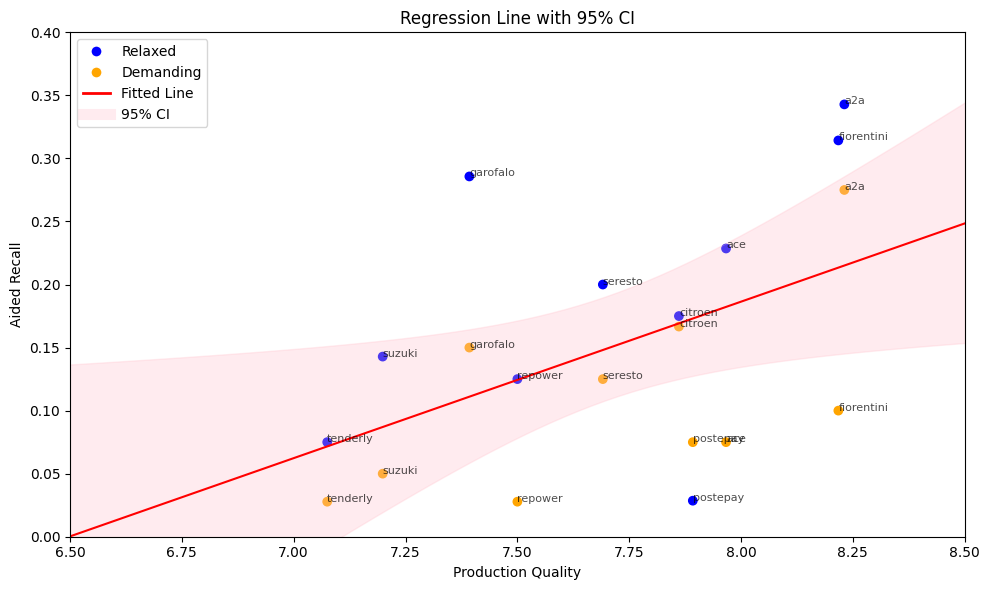

In [129]:
# Create predictor grid for smooth line
X_pred = np.linspace(6, 9, 100)  # Force range 0 to 10
X_pred_const = sm.add_constant(X_pred)

# Get prediction and confidence intervals
predictions = model.get_prediction(X_pred_const)
pred_summary = predictions.summary_frame(alpha=0.05)

# Color mapping
color_map = {'relaxed': 'blue', 'demanding': 'orange'}
colors = df_filtered['condition'].map(color_map)

plt.figure(figsize=(10, 6))

# Scatter plot with colors
plt.scatter(X['production-quality'], y, c=colors, label="Observed")

# Annotate each point with brand
for i, row in df_filtered.iterrows():
    plt.annotate(row['brand'], (row['production-quality'], row['aided']), fontsize=8, alpha=0.7)

# Plot regression line
plt.plot(X_pred, pred_summary['mean'], color="red", label="Fitted Line")

# Plot confidence interval
plt.fill_between(X_pred, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'], color="pink", alpha=0.3, label="95% CI")

plt.xlabel("Production Quality")
plt.ylabel("Aided Recall")
plt.title("Regression Line with 95% CI")

# Custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Relaxed', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Demanding', markerfacecolor='orange', markersize=8),
    Line2D([0], [0], color='red', lw=2, label='Fitted Line'),
    Line2D([0], [0], color='pink', lw=8, alpha=0.3, label='95% CI')
]
plt.legend(handles=legend_elements)

# Set x-axis limits
plt.xlim(6.5, 8.5)
plt.ylim(0, 0.4)

plt.tight_layout()
plt.show()